# JLS bibliometry

## Preparation

In [4]:
# Uncomment and run once
# if you use vanilla python:
#   !pip install py2neo python-dotenv pandas pyvis ipywidgets
# OR if you use anaconda:
#   !conda install -c conda-forge py2neo python-dotenv ipywidgets
#   !conda install panda pyvis
# for table of contents support, see https://github.com/ipython-contrib/jupyter_contrib_nbextensions

## Most published BJLS/JLS authors (crossref.org)

In [61]:
query ="""
match (a:Author)-[:CREATOR_OF]->(w:Work)
where w.url <> ""
and ( (w)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'}) or (w)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'}) )
return a.display_name as Author, count(distinct w) as PublicationCount
order by PublicationCount desc
limit 100
"""
from scripts.utils import get_graph
get_graph("jls3").run(query).to_data_frame()

,Author,PublicationCount
0,"cotterrell, r",17
1,"campbell, d",14
2,"hunt, a",13
3,"cowan, d",12
4,"wheeler, s",12
...,...,...
95,"bridges, l",4
96,"webb, j",4
97,"smith, c",4
98,"gunningham, n",4


## Most-published authors in the BJLS, timeseries (crossref.org)


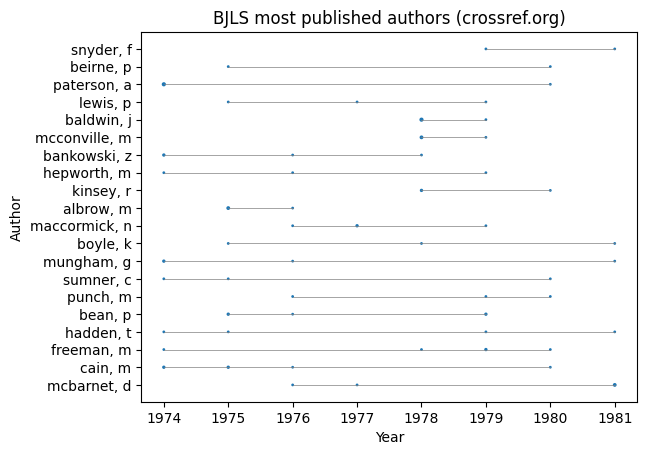

In [58]:
query ="""
match (a:Author)-[:CREATOR_OF]->(w:Work)
where w.url <> ""
    and (w)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'})
with a, count(distinct w) as count
order by count desc
limit 20
where count > 1
with a
match (a)-[:CREATOR_OF]->(w:Work)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'})
return a.display_name as author,
    w.year as year,
    count(distinct w) as count
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
data = get_graph("jls3").run(query).to_data_frame()
plot_by_year(data, dep_col='author', dep_label="Author",
             file="docs/bjls-ts-most-published-authors.png",
             title="BJLS most published authors (crossref.org)")

## Most-published authors in the JLS, timeseries (crossref.org)

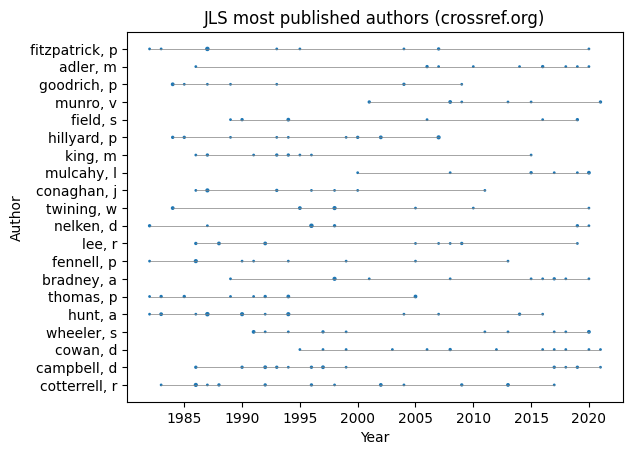

In [59]:
query ="""
match (a:Author)-[:CREATOR_OF]->(w:Work)
where w.url <> ""
    and (w)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
with a, count(distinct w) as count
order by count desc
limit 20
match (a)-[:CREATOR_OF]->(w:Work)
where (w)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'})
return a.display_name as author,
    w.year as year,
    count(distinct w) as count
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
data = get_graph("jls3").run(query).to_data_frame()
plot_by_year(data, dep_col='author', dep_label="Author",
             file="docs/jls-ts-most-published-authors.png",
             title="JLS most published authors (crossref.org)")

## Network of 20 most-published authors with 10 authors they cite (most), per decade (extraction data)

In [67]:
query = """
// find all authors who have published in the JLS in the given period, and use the 20 most-published ones
match (a1:Author)-[:CREATOR_OF]->(w:Work)
where a1.family <> "no_author"
    and w.year >= $year_start AND w.year <= $year_end
    and ((w)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'}) or (w)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'}))
with a1, count(distinct w) as count
order by count desc
limit 20

// style the nodes to reflect the number of publications
set a1.value = count
set a1.group = "citingAuthor"
set a1.label = (a1.display_name + "\n(" + toString(count) + " publications)")

// find the authors cited most by these most-published authors in their work in the given period
with a1
call {
    with a1
    match (a1)-[:CREATOR_OF]->(w1:Work)-[citation:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
    where a2.family <> "no_author"
        and w1.year >= $year_start AND w1.year <= $year_end
        and a1 <> a2
    with a2, count(citation) as citCount
    where citCount > 1
    with a2, citCount
    order by citCount desc
    limit 10
    with a2
    // size the cited author's node according to the total amount of citations of this author in the given period
    call {
        with a2
        optional match (a1:Author)-[:CREATOR_OF]->(:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(a2)
        where citedWork.year >= $year_start AND citedWork.year <= $year_end
            and a1 <> a2
        with a2, count(citation) as citationCount
        set a2.value = citationCount
    }
    return a2
}
set a2.group = CASE WHEN exists(a2.group) THEN a2.group ELSE "citedAuthor" END
with a1, a2
match (a1)-[:CREATOR_OF]->(w1:Work)-[citation:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
where w1.year >= $year_start AND w1.year <= $year_end
    and ((w1)-[:PUBLISHED_IN]->(:Venue {id: 'j law soc'}) or (w1)-[:PUBLISHED_IN]->(:Venue {id: 'br j law soc'}))
with a1, a2, count(citation) as citationCount
return a1,
    apoc.create.vRelationship(a1, 'CITES', {value: citationCount, label:toString(citationCount)}, a2),
    a2
"""
from scripts.pyvis import create_timeseries
from scripts.utils import get_graph
graph = get_graph("jls3")
create_timeseries(graph, query,
                  min_edge_value=1,
                  url="https://cboulanger.github.io/jls-bibliometry",
                  file_prefix="docs/",
                  file_id="jls-most-published-with-cited-authors",
                  title="Most published authors with main cited authors",
                  caption="Network shows the 20 most published authors in the time period, with the 10  most-cited authors in their works")
graph.run("match (a:Author) remove a.value, a.label, a.group")

(No data)

## Network of top 10 most cited authors of each decade with 10 most-citing authors (extraction data)

In [66]:
query = """
// find all cited works that were cited in the given period, excluding self-citations
MATCH (citingAuthor)-[:CREATOR_OF]->(citingWork:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE citingWork.year >= $year_start AND citingWork.year <= $year_end
    AND citingAuthor.family <> "no_author"
    AND citedAuthor.family <> "no_author"
    AND citingAuthor <> citedAuthor

// get the 10 most-cited authors
WITH citedAuthor, count(distinct citation) as citationCount
ORDER BY citationCount DESC
LIMIT 10

// add the total citation count to the label and size the author node according to this amount
set citedAuthor.label = (citedAuthor.display_name + "\n(" + toString(citationCount) + " citations)")
set citedAuthor.value = citationCount
set citedAuthor.group = "citedAuthor"

// get the 10 authors that cite these authors most in the given period
with citedAuthor
CALL {
    WITH citedAuthor
    MATCH (citingAuthor)-[:CREATOR_OF]->(citingWork:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor)
    WHERE citingWork.year >= $year_start AND citingWork.year <= $year_end
    and citingAuthor.family <> "no_author"
    with citingAuthor, count(citation) as citationCount
    // and style their node according to their own citation weight in that period
    CALL {
        WITH citingAuthor
        OPTIONAL MATCH (:Work)-[citation:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citingAuthor)
        WITH citingAuthor, count(citation) as citationCount
        SET citingAuthor.value = citationCount
        SET citingAuthor.group = CASE WHEN exists(citingAuthor.group) THEN citingAuthor.group ELSE "citingAuthor" END
    }
    return citingAuthor
    order by citationCount desc
    limit 10
}

// count the number of citations between citing and cited author in the given period of time and create relationships
WITH citedAuthor, citingAuthor
MATCH path = (citedAuthor)-[:CREATOR_OF]->(citedWork:Work)<-[citation:CITES]-(citingWork:Work)<-[:CREATOR_OF]-(citingAuthor)
WHERE citingWork.year >= $year_start AND citingWork.year <= $year_end
WITH citedAuthor, citingAuthor, COUNT(citation) AS citationCount

// return nodes and a virtual relationships between them
RETURN citingAuthor,
    apoc.create.vRelationship(citingAuthor, 'CITES', {value: citationCount, label:toString(citationCount)}, citedAuthor),
    citedAuthor

"""
from scripts.utils import get_graph
from scripts.pyvis import create_timeseries
graph = get_graph("jls3")
create_timeseries(graph, query,
                  url="https://cboulanger.github.io/jls-bibliometry",
                  file_prefix="docs/",
                  file_id="jls-most-cited-with-most-citing",
                  title="JLS most-cited authors with most-citing authors")
graph.run("match (a:Author) remove a.group, a.label, a.value, a.title")

(No data)

## Co-Citation network (extraction data)


In [ ]:
query = """
MATCH p=(a1:Author)-[:CREATOR_OF]->(:Work)<-[:CITES]-(:Work)-[:CITES]->(:Work)<-[:CREATOR_OF]-(a2:Author)
where a1.family <> "no_author" and a2.family <> "no_author"
with a1, a2, COUNT(distinct p) as co_citations
where id(a1) < id(a2) AND co_citations >= 100
set a1.group ="", a2.group=""
with a1, a2, co_citations
CALL apoc.create.vRelationship(a1, "IS_COCITED_WITH", {value: co_citations, label: toString(co_citations)}, a2)
YIELD rel
RETURN a1, rel, a2
ORDER BY rel.value DESC
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
graph = get_graph("jls2")
draw(graph, query,
     title="JLS co-citation network for >= 100 co-citations",
     file="docs/jls-co-citation-network.html", height="800px",
     seed=2, link_only=True)

## Most-cited authors, table (extraction data)

In [ ]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author"
return citedAuthor.display_name as `Author`, count(*) as `Citation count`
order by `Citation count` desc
limit 30
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

In [ ]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Author'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Author')
plt.title('Author Citation Count')
plt.savefig("docs/jls-most-cited-authors.png", bbox_inches="tight")
plt.show()

## Most-cited authors, timeseries (extraction data)

In [ ]:
query = """
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
where citedAuthor.family <> "no_author"
with citedAuthor, count(r) as citationCount
order by citationCount desc
limit 30
match (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor)
RETURN citedAuthor.display_name as author,
    citingWork.year as year,
    count(r) as count
order by year
"""
from scripts.utils import get_graph
from scripts.occurrence_by_year_scatter import plot_by_year
graph = get_graph("jls2")
data = graph.run(query).to_data_frame()
plot_by_year(data, dep_col="author", dep_label="Author",
             file="docs/jls-ts-most-cited.png",
             title="")

## Most-cited journals

In [ ]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
return citedVenue.name as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls2")
df = graph.run(query).to_data_frame()
df

In [ ]:
import matplotlib.pyplot as plt
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Most-cited journals in the JLS (extraction data)')
plt.savefig("docs/jls-most-cited-journals.png", bbox_inches="tight")
plt.show()

## Most-cited journals (WOS)

In [ ]:
query = """
match (citingWork:Work)-[r:CITES]->(:Work)-[:PUBLISHED_IN]-(citedVenue:Venue)
where exists((citingWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
return toLower(citedVenue.name) as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls-journal-network")
df = graph.run(query).to_data_frame()
df

In [ ]:
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Most-cited journals in the JLS (Web of Science)')
plt.savefig("docs/jls-most-cited-journals-wos.png", bbox_inches="tight")
plt.show()

## Most-citing journals (WOS)

In [ ]:
query = """
with "this is only to trigger syntax highlighting" as ignore
match (citedWork:Work)<-[r:CITES]-(:Work)-[:PUBLISHED_IN]-(citingVenue:Venue)
where exists((citedWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
return toLower(citingVenue.name) as `Journal name`, count(r) as `Citation count`
order by `Citation count` desc
limit 20
"""
from scripts.utils import get_graph
graph = get_graph("jls-journal-network")
df = graph.run(query).to_data_frame()
df

In [ ]:
df = df.sort_values('Citation count', ascending=True)
plt.barh(df['Journal name'], df['Citation count'])
plt.xlabel('Citation count')
plt.ylabel('Journal name')
plt.title('Journals citing the JLS most (Web of Science)')
plt.savefig("docs/jls-most-citing-journals-wos.png", bbox_inches="tight")
plt.show()

## Socio-legal journal citation network (hand-picked), over time (WOS)

In [ ]:
query = """
with [
    'journal of law and society',
    'social & legal studies',
    'law and critique',
    'feminist legal studies',
    'international journal of law in context',
    'british journal of criminology',
    'law & society review',
    'law and social inquiry-journal of the american bar foundation'
] as journals

match  p=(citingVenue:Venue)<-[:PUBLISHED_IN]-(citingWork:Work)-[:CITES]->(:Work)-[:PUBLISHED_IN]->(citedVenue:Venue)
where toLower(citingVenue.name) in journals and toLower(citedVenue.name) in journals
    and (toLower(citingVenue.name) = 'journal of law and society' or toLower(citedVenue.name) = 'journal of law and society')
    and citingWork.year >= $year_start and citingWork.year <= $year_end
    and citingVenue <> citedVenue
with citingVenue, citedVenue, count(p) as pathCount
call {
    with citingVenue
    optional match (:Venue)<-[:PUBLISHED_IN]-(:Work)-[citation:CITES]->(work:Work)-[:PUBLISHED_IN]->(citingVenue)
    where work.year >= $year_start and work.year <= $year_end
    with citingVenue, count(citation) as citationCount
    set citingVenue.value = citationCount
    set citingVenue.label = toLower(citingVenue.name)
}
call {
    with citedVenue
    optional match (:Venue)<-[:PUBLISHED_IN]-(:Work)-[citation:CITES]->(work:Work)-[:PUBLISHED_IN]->(citedVenue)
    where work.year >= $year_start and work.year <= $year_end
    with citedVenue, count(citation) as citationCount
    set citedVenue.value = citationCount
    set citedVenue.label = toLower(citedVenue.name)
}
return citingVenue,
    citedVenue,
    apoc.create.vRelationship(citingVenue, 'CITES', {value: pathCount, label: toString(pathCount)}, citedVenue)
"""
from scripts.utils import get_graph
from scripts.pyvis import create_timeseries
graph = get_graph("jls-journal-network")
create_timeseries(graph, query,
                  url="https://cboulanger.github.io/jls-bibliometry",
                  file_prefix="docs/",
                  file_id="jls-socio-legal-network-selected",
                  title="Socio-legal journal network: selected journals",
                  caption="Journals have been manually selected. Size of the nodes represent the total citations of the journal in the dataset in the given period. Source: Web of Science. ")
graph.run("match (v:Venue) remove v.value, v.label")


## Socio-legal network: top-twenty "close" journals (WOS)

In [ ]:
query = """with "cypher" as syntax
//-- get the top 20 cited/citing in the given period
match (citedWork:Work)<-[r:CITES]-(citingWork:Work)-[:PUBLISHED_IN]-(citingVenue:Venue)
where (exists((citedWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
        and citedWork.year >= $year_start and citedWork.year <= $year_end)
    or (exists((citingWork)-[:PUBLISHED_IN]->(:Venue {name:"JOURNAL OF LAW AND SOCIETY"}))
        and citingWork.year >= $year_start and citingWork.year <= $year_end)
with toLower(citingVenue.name) as journal, count(r) as citationCount
order by citationCount desc
limit 20
with collect(journal) as journals

match  p=(citingVenue:Venue)<-[:PUBLISHED_IN]-(citingWork:Work)-[:CITES]->(:Work)-[:PUBLISHED_IN]->(citedVenue:Venue)
where toLower(citingVenue.name) in journals and toLower(citedVenue.name) in journals
    and citingWork.year >= $year_start and citingWork.year <= $year_end
    and citingVenue <> citedVenue
with citingVenue, citedVenue, count(p) as pathCount
with citingVenue, citedVenue, pathCount
call {
    with citingVenue
    optional match (:Venue)<-[:PUBLISHED_IN]-(:Work)-[citation:CITES]->(work:Work)-[:PUBLISHED_IN]->(citingVenue)
    where work.year >= $year_start and work.year <= $year_end
    with citingVenue, count(citation) as citationCount
    set citingVenue.value = citationCount
    set citingVenue.label = toLower(citingVenue.name)
    set citingVenue.group = case when citingVenue.label = "journal of law and society" then "jls" else null end
}
call {
    with citedVenue
    optional match (:Venue)<-[:PUBLISHED_IN]-(:Work)-[citation:CITES]->(work:Work)-[:PUBLISHED_IN]->(citedVenue)
    where work.year >= $year_start and work.year <= $year_end
    with citedVenue, count(citation) as citationCount
    set citedVenue.value = citationCount
    set citedVenue.label = toLower(citedVenue.name)
    set citedVenue.group = case when citedVenue.label = "journal of law and society" then "jls" else null end
}
return citingVenue, citedVenue,
    apoc.create.vRelationship(
        citingVenue,
        'CITES', {
            value: pathCount,
            label: toString(pathCount)
        },
        citedVenue)
"""
from scripts.utils import get_graph
from scripts.pyvis import create_timeseries
graph = get_graph("jls-journal-network")
create_timeseries(graph, query,
                  url="https://cboulanger.github.io/jls-bibliometry",
                  file_prefix="docs/",
                  file_id="jls-socio-legal-network-top-20",
                  title="Socio-legal journal network, 20 closest journals",
                  seed=1,
                  caption="Included are the 20 journals most cited by the JLS or citing the JLS most in the given period. Sizes of the nodes represent the total citations of the journal in the dataset in the given period. Source: Web of Science.")
graph.run("match (v:Venue) remove v.value, v.label")

## Author network (Cownie/Bradney)

In [ ]:
query = """
MATCH path=(a1:Author)-[:CREATOR_OF]->(w1:Work)-[c:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.family = "cownie" OR a2.family = "cownie" or a1.family = "bradney" OR a2.family = "bradney"
    and ((w1)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}) or (w2)-[:PUBLISHED_IN]->(:Venue {id:"j law soc"}))
WITH a1, a2, count(c) as citations
WHERE citations >= 4
WITH collect(a1) + collect(a2) as authorNetwork, citations
UNWIND authorNetwork as authors
MATCH p2=(authors)-[:CREATOR_OF]->(:Work)-[c:CITES]->(:Work)<-[:CREATOR_OF]-(citingAuthor:Author)
WHERE citingAuthor in authorNetwork
WITH authors, citingAuthor, count(c) as citations
where authors.family <> "no_author" and citingAuthor.family <> "no_author" and authors <> citingAuthor
RETURN authors as source_node,
    apoc.create.vRelationship(authors, 'CITES', {value: citations}, citingAuthor) as rel,
    citingAuthor as target_node
"""
from scripts.pyvis import draw
from scripts.utils import get_graph
draw(get_graph("jls2"), query)